# Topic Modeling with SciKit Learn

In this notebook we create a topic model from our corpus  using SciKit Learn's library. We'll save our results and then use another notebook to explore the results.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np
from lib import tapi

## Configuration

In [2]:
tapi.list_corpora()

['airbnb',
 'anphoblacht',
 'arxiv',
 'covid19',
 'jstor_hyperparameter',
 'novels',
 'okcupid',
 'tamilnet',
 'winereviews',
 'yelp',
 'zuboff']

In [3]:
# data_prefix = 'winereviews'
# data_prefix = 'tamilnet'
data_prefix = 'anphoblacht'

In [4]:
db = tapi.Edition(data_prefix)

## Parameters

In [5]:
n_terms = 4000 # Vocabulary size
ngram_range = (1,4) # ngram min and max lengths
n_topics = 20 # Number of topics
max_iter = 5 # Number of iterations for topic model

In [6]:
topic_cols = [t for t in range(n_topics)]

## Create Tables Object

These tables constitute a "digital critical edition."

# Import Corpus Data

We import a corpus in our standard format

In [7]:
corpus = db.get_corpus()

## Inspect contents

In [8]:
corpus.head(10)

,doc_key,doc_title,doc_year,doc_content,doc_original,doc_date,doc_label,doc_url
doc_id,,,,,,,,
0,11324,RUC members seek compensation over Hamill murder,2004,two ruc members who were on duty in a land rov...,two ruc members who were on duty in a land rov...,2004-3-4,2004,/11324.html
1,1914,New in print,1997,the seven deadly crises criminal chaos seven c...,the seven deadly crises criminal chaos seven c...,1997-4-10,1997,/1914.html
2,678,"Day 1, General Election 2011 – Gerry Adams say...",2011,sinn féin tds pearse doherty aengus ó snodaigh...,sinn féin tds pearse doherty aengus ó snodaigh...,2011-2-2,2011,/678.html
3,15342,Críochdheighilt Aitheanta ar Léarscáileanna,2006,by cathal o murchu tá sé curtha i leith i gcoi...,by cathal o murchu tá sé curtha i leith i gcoi...,2006-6-8,2006,/15342.html
4,8589,Welcome for All-Ireland health moves,2002,sinn féin assmbly health spokesperson john kel...,sinn féin assmbly health spokesperson john kel...,2002-3-28,2002,/8589.html
5,7192,Nigerians face deportation,2001,on monday evening there were two quite innocen...,on monday evening there were two quite innocen...,2001-2-15,2001,/7192.html
6,16986,International : Spanish courts do State's bidding,2007,batasuna spokesperson arnaldo otegi speaking a...,batasuna spokesperson arnaldo otegi speaking a...,2007-6-14,2007,/16986.html
7,8046,"Different name, same bigots",2001,ruc replaced by psni by fern lane racism does ...,ruc replaced by psni by fern lane racism does ...,2001-11-8,2001,/8046.html
8,20394,O'Dowd concern after PSNI shoot man in stolen car,2009,sinn féin assembly member for upper bann john ...,sinn féin assembly member for upper bann john ...,2009-7-23,2009,/20394.html


In [9]:
corpus.shape

(10000, 8)

In [10]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   doc_key       10000 non-null  int64 
 1   doc_title     10000 non-null  object
 2   doc_year      10000 non-null  int64 
 3   doc_content   10000 non-null  object
 4   doc_original  10000 non-null  object
 5   doc_date      10000 non-null  object
 6   doc_label     10000 non-null  int64 
 7   doc_url       10000 non-null  object
dtypes: int64(3), object(5)
memory usage: 625.1+ KB


# Create Bag-of-Words 

ie. a __Count Vector Space__

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [12]:
count_engine = CountVectorizer(max_features=n_terms, stop_words='english', ngram_range=ngram_range)
count_model = count_engine.fit_transform(corpus.doc_content)

In [13]:
# corpus.doc_content

## Get Generated VOCAB

In [14]:
db.VOCAB = pd.DataFrame(count_engine.get_feature_names(), columns=['term_str'])
db.VOCAB = db.VOCAB.set_index('term_str')
db.VOCAB['ngram_len'] = None # To be added later
# VOCAB.index.name = 'term_id' # For convenience, we'll use strings for IDs

In [15]:
db.VOCAB.sample(10)

,ngram_len
term_str,
laura,None
grounds,None
suggests,None
proposal,None
sure,None
repression,None
employees,None
dpp,None
joanne,None


## Get Generated BOW

We do this just to show what the counter vectorizer produced. `DTM` stands for documet-term matrix. We convert this sparse matrix into a "thin" dataframe that keeps only terms with counts for each document. 

In [16]:
db.DTM = pd.DataFrame(count_model.toarray(), index=corpus.index, columns=db.VOCAB.index)
db.BOW = db.DTM.stack().to_frame('n')
db.BOW = db.BOW[~(db.BOW.n == 0)]

In [17]:
# db.BOW.head(10)

In [18]:
db.DTM.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 4000 entries, 000 to úsáid
dtypes: int64(4000)
memory usage: 305.2 MB


In [19]:
db.BOW.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1627724 entries, (0, '12') to (9999, 'years')
Columns: 1 entries, n to n
dtypes: int64(1)
memory usage: 18.8+ MB


## Compute TF-IDF

In [20]:
tfidf_engine = TfidfTransformer()
tfidf_model = tfidf_engine.fit_transform(count_model)

In [21]:
db.TFIDF = pd.DataFrame(tfidf_model.toarray(), index=corpus.index, columns=db.VOCAB.index)

In [22]:
db.BOW['tfidf'] = db.TFIDF.stack()

In [23]:
db.BOW

n     tfidf
doc_id term_str               
0      12          1  0.068452
       1997        2  0.186228
       1999        1  0.093171
       25          1  0.073885
       27          1  0.086463
...               ..       ...
9999   widespread  1  0.032535
       women       1  0.022659
       work        1  0.017294
       world       1  0.020361
       years       1  0.013747

[1627724 rows x 2 columns]

## Add Features to VOCAB

In [24]:
db.VOCAB['ngram_len'] = db.VOCAB.apply(lambda x: len(x.name.split()), 1)
db.VOCAB['n'] = db.DTM.sum()
db.VOCAB['tfidf_mean'] = db.TFIDF.mean()

In [25]:
db.VOCAB

,ngram_len,n,tfidf_mean
term_str,,,
000,1,3587,0.009137
000 people,2,483,0.002025
10,1,1903,0.005488
10 000,2,168,0.000864
100,1,991,0.003970
...,...,...,...
ógra,1,680,0.003618
ógra shinn,2,386,0.002227
ógra shinn féin,3,383,0.002205


<AxesSubplot:>

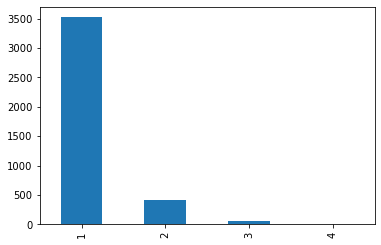

In [26]:
db.VOCAB.ngram_len.value_counts().plot.bar()

# Generate Topic Models

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [27]:
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF

## Using LDA

In [28]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

### THETA

In [29]:
db.THETA = pd.DataFrame(lda_engine.fit_transform(count_model), index=corpus.index)
db.THETA.index.name = 'doc_id'
db.THETA.columns.name = 'topic_id'

In [30]:
db.THETA.sample(20).T.style.background_gradient()

doc_id,5942,5270,2870,2359,4603,1657,992,4667,966,3677,9437,2692,3610,9467,4651,7388,6351,2705,9201,369
topic_id,,,,,,,,,,,,,,,,,,,,
0,0.000568,0.000316,0.000180,0.000253,0.000427,0.000303,0.000225,0.048026,0.000538,0.000050,0.000229,0.101880,0.000296,0.000229,0.000847,0.000336,0.000500,0.000198,0.000296,0.028948
1,0.000568,0.634248,0.000180,0.058001,0.000427,0.139916,0.000225,0.000199,0.000538,0.000050,0.000229,0.000104,0.000296,0.000229,0.141323,0.000336,0.000500,0.000198,0.325637,0.000180
2,0.045479,0.000316,0.107080,0.000253,0.000427,0.000303,0.000225,0.000199,0.000538,0.999050,0.000229,0.000104,0.000296,0.000229,0.000847,0.000336,0.039866,0.000198,0.162611,0.000180
3,0.000568,0.000316,0.190025,0.000253,0.000427,0.000303,0.000225,0.000199,0.000538,0.000050,0.000229,0.000104,0.000296,0.000229,0.000847,0.000336,0.000500,0.145751,0.000296,0.000180
4,0.000568,0.069003,0.000180,0.000253,0.000427,0.000303,0.000225,0.000199,0.000538,0.000050,0.187056,0.067409,0.000296,0.000229,0.000847,0.000336,0.000500,0.078131,0.000296,0.015200
5,0.000568,0.000316,0.000180,0.000253,0.000427,0.322127,0.000225,0.000199,0.000538,0.000050,0.000229,0.000104,0.000296,0.000229,0.153255,0.000336,0.000500,0.000198,0.000296,0.000180
6,0.000568,0.000316,0.000180,0.000253,0.136852,0.000303,0.000225,0.000199,0.000538,0.000050,0.000229,0.000104,0.626686,0.000229,0.000847,0.993624,0.000500,0.000198,0.000296,0.000180
7,0.000568,0.000316,0.000180,0.000253,0.000427,0.000303,0.000225,0.000199,0.000538,0.000050,0.000229,0.000104,0.000296,0.000229,0.000847,0.000336,0.084875,0.000198,0.000296,0.000180
8,0.098953,0.000316,0.653604,0.000253,0.401283,0.000303,0.000225,0.000199,0.000538,0.000050,0.000229,0.536440,0.279280,0.000229,0.000847,0.000336,0.000500,0.277711,0.075070,0.333802


### PHI

In [31]:
db.PHI = pd.DataFrame(lda_engine.components_, columns=db.VOCAB.index)
db.PHI.index.name = 'topic_id'
db.PHI.columns.name  = 'term_str'

In [32]:
db.PHI.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
term_str,,,,,,,,,,,,,,,,,,,,
000,97.430440,27.638090,2.161695,60.016185,111.797715,294.531260,76.729395,145.746150,202.375052,0.050005,9.807252,1091.679545,29.744451,3.942214,113.812927,107.608173,639.834570,151.612368,200.665663,220.816850
000 people,22.018166,16.400299,0.970697,18.053969,12.959039,38.922841,4.126530,10.309286,51.548020,0.050000,0.163412,92.023570,5.691782,1.109856,0.108138,6.258459,99.533711,14.774113,44.853817,44.124294
10,33.628232,35.612731,132.050432,25.612731,52.861771,72.790577,530.908345,59.736834,121.456071,68.262896,5.348420,229.179600,26.660174,14.488387,21.247855,170.281873,137.413389,86.439010,21.773631,58.247040
10 000,12.424321,0.050000,0.123920,2.269272,15.324688,13.410385,1.259498,6.937300,31.008418,0.050000,0.050000,40.541375,0.278228,0.050000,1.954298,7.591564,20.137604,1.866093,6.065363,7.607672
100,8.540257,13.477278,1.141737,32.430536,34.542982,74.249064,241.553999,10.068039,65.008727,0.054216,8.775924,201.223221,13.174994,6.437178,12.956358,41.666944,119.679479,36.317171,33.522652,37.179244


### Create Topic Glosses

In [33]:
n_top_words = 7

In [34]:
db.TOPICS = db.PHI.stack()\
    .to_frame('weight')\
    .groupby('topic_id')\
    .apply(lambda x: x.weight.sort_values(ascending=False)\
               .head(n_top_words)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [35]:
db.TOPICS

term_str,0,1,2,3,4,5,6
topic_id,,,,,,,
0,health,hospital,services,children,minister,care,service
1,sinn féin,féin,sinn,ireland,said,north,adams
2,volunteer,family,brigade,cumann,féin,sinn,sinn féin
3,orange,order,road,orange order,parade,residents,people
4,british,said,government,army,state,court,sunday
5,dublin,year,people,school,children,education,county
6,israeli,dublin,commemoration,palestinian,function,saturday,israel
7,british,ruc,murder,finucane,inquiry,said,killing
8,republican,hunger,prisoners,irish,british,people,ireland


In [36]:
db.TOPICS['topwords'] = db.TOPICS.apply(lambda x: str(x.name) + ' ' + ', '.join(x), 1)

In [37]:
# db.TOPICS.drop(topic_cols, 1)

In [38]:
db.TOPICS

term_str,0,1,2,3,4,5,6,topwords
topic_id,,,,,,,,
0,health,hospital,services,children,minister,care,service,"0 health, hospital, services, children, minist..."
1,sinn féin,féin,sinn,ireland,said,north,adams,"1 sinn féin, féin, sinn, ireland, said, north,..."
2,volunteer,family,brigade,cumann,féin,sinn,sinn féin,"2 volunteer, family, brigade, cumann, féin, si..."
3,orange,order,road,orange order,parade,residents,people,"3 orange, order, road, orange order, parade, r..."
4,british,said,government,army,state,court,sunday,"4 british, said, government, army, state, cour..."
5,dublin,year,people,school,children,education,county,"5 dublin, year, people, school, children, educ..."
6,israeli,dublin,commemoration,palestinian,function,saturday,israel,"6 israeli, dublin, commemoration, palestinian,..."
7,british,ruc,murder,finucane,inquiry,said,killing,"7 british, ruc, murder, finucane, inquiry, sai..."
8,republican,hunger,prisoners,irish,british,people,ireland,"8 republican, hunger, prisoners, irish, britis..."


### Add Doc Weights

In [39]:
db.TOPICS['doc_weight_sum'] = db.THETA.sum()

In [40]:
db.TOPICS.iloc[:, 7:].sort_values('doc_weight_sum', ascending=False).style.bar()

term_str,topwords,doc_weight_sum
topic_id,,
8,"8 republican, hunger, prisoners, irish, british, people, ireland",894.963487
16,"16 people, world, like, new, ireland, irish, war",875.247814
15,"15 ruc, said, belfast, area, loyalist, attack, sinn",855.627635
17,"17 sinn, féin, sinn féin, party, election, people, political",733.024172
11,"11 government, workers, tax, said, public, pay, social",715.131324
4,"4 british, said, government, army, state, court, sunday",669.574732
12,"12 agreement, process, british, political, peace, government, good",664.626039
19,"19 government, eu, irish, people, ireland, fianna, fianna fáil",626.119314
1,"1 sinn féin, féin, sinn, ireland, said, north, adams",573.015638


## Using NMF

In [41]:
nmf_engine = NMF(n_components=n_topics, init='nndsvd', random_state=1, alpha=.1, l1_ratio=.5)

### THETA

In [42]:
db.THETA_NMF = pd.DataFrame(nmf_engine.fit_transform(tfidf_model), index=corpus.index)
db.THETA_NMF.columns.name = 'topic_id'

In [43]:
db.THETA_NMF.sample(20).style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
doc_id,,,,,,,,,,,,,,,,,,,,
7856,0.003910,0.000000,0.075752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003616,0.000000,0.000000,0.000000
6642,0.028349,0.000000,0.036941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003422,0.000000,0.000000,0.021612,0.000000,0.000000,0.000000,0.000000,0.010617
5920,0.021938,0.000000,0.000000,0.000000,0.001797,0.000000,0.008845,0.000000,0.000640,0.005806,0.000000,0.000000,0.000000,0.000000,0.011238,0.000000,0.000000,0.000000,0.000000,0.000000
2054,0.010893,0.000000,0.000000,0.000000,0.047297,0.000492,0.000000,0.000000,0.000000,0.000000,0.000000,0.015875,0.025438,0.000000,0.000000,0.000000,0.003065,0.000000,0.000000,0.000000
8848,0.006101,0.000000,0.012316,0.000000,0.000491,0.015067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004580,0.000000,0.072844,0.000000,0.000000,0.000000,0.004347,0.000000
3021,0.027382,0.000000,0.020409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081434,0.000882,0.000000,0.000000,0.000000,0.004151,0.000000,0.000000,0.000000,0.000000
2221,0.015941,0.000000,0.000434,0.000000,0.002392,0.000000,0.011348,0.000000,0.000000,0.000000,0.000000,0.001743,0.000000,0.002460,0.005848,0.000000,0.000000,0.087061,0.000000,0.000000
8422,0.000000,0.000000,0.065512,0.000000,0.002106,0.003725,0.000000,0.123864,0.000000,0.000000,0.000000,0.039381,0.000266,0.003713,0.004293,0.000000,0.000000,0.000000,0.000000,0.000000
6171,0.000000,0.003063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.191775,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### PHI

In [44]:
db.PHI_NMF = pd.DataFrame(nmf_engine.components_, columns=db.VOCAB.index)

In [45]:
db.PHI_NMF.index.name = 'topic_id'
db.PHI_NMF.columns.name = 'term_str'

In [46]:
db.PHI_NMF.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
term_str,,,,,,,,,,,,,,,,,,,,
000,0.158476,0.015205,0.033975,0.000000,0.000000,0.000000,0.036661,0.000000,0.000000,0.021438,0.000000,0.000000,0.019397,0.000000,0.407618,0.041635,0.023503,0.011882,0.000000,0.074578
000 people,0.053537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006371,0.000000,0.000000,0.000000,0.064321,0.020551,0.000000,0.000000,0.000000,0.001449
10,0.041619,0.000550,0.020979,0.000000,0.000000,0.000000,0.063101,0.000000,0.031318,0.439179,0.004173,0.009346,0.000000,0.011390,0.098126,0.008879,0.012619,0.000000,0.000000,0.002153
10 000,0.011997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000216,0.000000,0.000000,0.000000,0.001083,0.000000,0.000000,0.000000,0.032468,0.000000,0.000000,0.000000,0.000000,0.000000
100,0.062720,0.000000,0.000000,0.320899,0.003872,0.000000,0.014629,0.000000,0.000000,0.090815,0.000000,0.000000,0.002887,0.000000,0.086554,0.000000,0.003757,0.000071,0.000000,0.000000


### Topics

In [47]:
db.TOPICS_NMF = db.PHI_NMF.stack()\
    .to_frame('weight')\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(n_top_words)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [48]:
db.TOPICS_NMF

term_str,0,1,2,3,4,5,6
topic_id,,,,,,,
0,irish,people,ireland,republican,women,years,war
1,ar,agus,na,ag,le,tá,bhí
2,british,army,british army,british government,government,collusion,military
3,galleria,flickr,var,data,description,function,true
4,sinn féin,sinn,féin,party,election,council,adams
5,agreement,process,political,good friday,peace,friday agreement,good friday agreement
6,loyalist,attack,loyalists,psni,attacks,belfast,catholic
7,inquiry,bloody sunday,bloody,sunday,saville,derry,evidence
8,volunteer,brigade,loving,loving memory,cumann,memory,remembered


In [49]:
db.TOPICS_NMF['topwords'] = db.TOPICS_NMF.apply(lambda x: str(x.name) + ' ' + ', '.join(x), 1)

### Add Doc Weights

In [50]:
db.TOPICS_NMF['doc_weight_sum'] = db.THETA_NMF.sum()

In [51]:
db.TOPICS_NMF.iloc[:, 7:].sort_values('doc_weight_sum', ascending=False).style.bar()

term_str,topwords,doc_weight_sum
topic_id,,
0,"0 irish, people, ireland, republican, women, years, war",167.219522
14,"14 workers, government, health, tax, services, public, pay",114.352589
4,"4 sinn féin, sinn, féin, party, election, council, adams",108.725032
5,"5 agreement, process, political, good friday, peace, friday agreement, good friday agreement",88.799528
6,"6 loyalist, attack, loyalists, psni, attacks, belfast, catholic",85.047365
2,"2 british, army, british army, british government, government, collusion, military",77.064935
1,"1 ar, agus, na, ag, le, tá, bhí",64.753399
11,"11 rights, human rights, human, court, policing, justice, psni",59.910762
12,"12 fianna fáil, fianna, fáil, fine gael, gael, fine, labour",52.999195


# Save the Model

## Keep Corpus Label Info

This is effectively the LIB table.

In [52]:
db.LABELS = corpus[set(corpus.columns.tolist()) - set(['doc_key', 'doc_content', 'doc_original'])]

## Save Tables

In [53]:
db.save_tables()

In [54]:
# See if it worked ...

!ls -l ./db/{data_prefix}*.csv

-rw-r--r--@ 1 rca2t1  staff  56870696 Jun 14 15:44 ./db/anphoblacht-BOW.csv
-rw-r--r--@ 1 rca2t1  staff  80098217 Jun 14 15:44 ./db/anphoblacht-DTM.csv
-rw-r--r--@ 1 rca2t1  staff    765374 Jun 14 15:44 ./db/anphoblacht-LABELS.csv
-rw-r--r--@ 1 rca2t1  staff   1546076 Jun 14 15:44 ./db/anphoblacht-PHI.csv
-rw-r--r--  1 rca2t1  staff    714061 Jun 14 15:44 ./db/anphoblacht-PHI_NMF.csv
-rw-r--r--@ 1 rca2t1  staff   4417280 Jun 14 15:44 ./db/anphoblacht-THETA.csv
-rw-r--r--@ 1 rca2t1  staff   1866177 Jun 14 15:44 ./db/anphoblacht-THETA_NMF.csv
-rw-r--r--@ 1 rca2t1  staff      2690 Jun 14 15:44 ./db/anphoblacht-TOPICS.csv
-rw-r--r--@ 1 rca2t1  staff      2976 Jun 14 15:44 ./db/anphoblacht-TOPICS_NMF.csv
-rw-r--r--@ 1 rca2t1  staff    145009 Jun 14 15:44 ./db/anphoblacht-VOCAB.csv
